# 0. required packages for h5py

In [1]:
%run "..\Startup_py3.py"
sys.path.append(r"..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

70336


# 1. Create field-of-view class

In [5]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

before_fov_param = {'data_folder':r'\\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\Before_clearing',
                   #'save_folder':r'V:\20201221-Acr_ctp08_P_brain\Before_clearing',
                   'save_folder':r'\\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\before_clearing', # use outside crick
                   'experiment_type': 'DNA',
                   'num_threads': 12,
                   'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201204-Corrections_3color_50',
                   'shared_parameters':{
                         'single_im_size':[50,2048,2048],
                         'corr_channels':['750','647'],
                         'num_empty_frames': 0, 
                         'corr_hot_pixel':True,
                         'corr_Z_shift':False,
                         'min_num_seeds':500,
                         'max_num_seeds': 2500,
                         'spot_seeding_th':150,
                         'normalize_intensity_local':False,
                         'normalize_intensity_background':False,
                     },             
             }

after_fov_param = {'data_folder':r'\\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\After_clearing',
                   #'save_folder':r'V:\20201221-Acr_ctp08_P_brain\After_clearing',
                   'save_folder':r'\\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\After_clearing', # use outside crick
                   'experiment_type': 'DNA',
                   'num_threads': 12,
                   'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201204-Corrections_3color_50', 
                   'shared_parameters':{
                         'single_im_size':[50,2048,2048],
                         'corr_channels':['750','647'],
                         'num_empty_frames': 0, 
                         'corr_hot_pixel':True,
                         'corr_Z_shift':False,
                         'min_num_seeds':500,
                         'max_num_seeds': 2500,
                         'spot_seeding_th':150,
                         'normalize_intensity_local':False,
                         'normalize_intensity_background':False,
                     },             
             }

#fov_ids = np.arange(5,11)
fov_ids = np.arange(5,6)
#fov_ids = np.concatenate([np.arange(5,11), np.arange(36,50)])

In [6]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes

overwrite_spot=False
overwrite_chrom=False
intensity_th = 200

before_fov_ids_list = []
before_chrom_ims = []
before_chrom_coords_list = []
before_cand_chr_spots_list = []

for _fov_id in fov_ids:

    # create fov class
    before_fov = classes.field_of_view.Field_of_View(before_fov_param, _fov_id=_fov_id,
        _color_info_kwargs={
          '_color_filename':'Color_Usage',
        }, 
        _prioritize_saved_attrs=False,
        )

    # process image into spots
    before_id_list, before_spot_list = before_fov._process_image_to_spots('unique', 
         #_sel_ids=np.arange(41,72),
         _load_common_reference=True,
         _load_with_multiple=False,
         _save_images=True,
         _warp_images=False, 
         _overwrite_drift=False,
         _overwrite_image=False,
         _overwrite_spot=overwrite_spot,
         _verbose=True)
    # identify chromosomes
    before_fov._load_from_file('unique')
    
    if not hasattr(before_fov, 'chrom_im'):
        _chrom_im = before_fov._load_chromosome_image(_overwrite=overwrite_chrom)
    if not hasattr(before_fov, 'chrom_coords'):
        _chrom_coords = before_fov._find_candidate_chromosomes_by_segmentation(
            _filt_size=4,
            _binary_per_th=99.75,
            _morphology_size=5,
            _overwrite=overwrite_chrom)
        _chrom_coords = before_fov._select_chromosome_by_candidate_spots(
            _good_chr_loss_th=0.5, _cand_spot_intensity_th=intensity_th,
            _overwrite=overwrite_chrom,
            _save=True)

    # append
    before_chrom_ims.append(before_fov.chrom_im)
    before_chrom_coords_list.append(before_fov.chrom_coords)
    before_fov_ids_list.append(_fov_id*np.ones(len(before_fov.chrom_coords)))
    
    before_fov_cand_chr_spots_list = [[] for _ct in before_fov.chrom_coords]

    # finalize candidate spots
    for _spots in before_fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, before_fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            before_fov_cand_chr_spots_list[_i].append(_cands)
            
    before_cand_chr_spots_list += before_fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(before_fov.chrom_coords)}")

# combine acquired spots and chromosomes
before_chrom_coords = np.concatenate(before_chrom_coords_list)
before_fov_ids_list = np.concatenate(before_fov_ids_list).astype(np.int)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
before_dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, before_fov.shared_parameters['distance_zxy'])
                       for _spots in before_cand_chr_spots_list]
before_dna_reg_ids = before_fov.unique_ids

print(f"{len(before_chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 88
- Importing csv file: \\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\Before_clearing\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 11 folders are found according to color-usage annotation.
+ loading fov_info from file: \\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\before_clearing\Conv_zscan_05.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 10.410s.
+ loading correction from file: \\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\before_clearing\Conv_zscan_05.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: 

E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


In [13]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes

overwrite_spot=False
overwrite_chrom=False
#intensity_th = 200

after_fov_ids_list = []
after_chrom_ims = []
after_chrom_coords_list = []
after_cand_chr_spots_list = []

for _fov_id in fov_ids:

    # create fov class
    after_fov = classes.field_of_view.Field_of_View(after_fov_param, _fov_id=_fov_id,
        _color_info_kwargs={
          '_color_filename':'Color_Usage',
        }, 
        _prioritize_saved_attrs=False,
        )

    # process image into spots
    after_id_list, after_spot_list = after_fov._process_image_to_spots('unique', 
         #_sel_ids=np.arange(41,72),
         _load_common_reference=True,
         _load_with_multiple=False,
         _save_images=True,
         _warp_images=False, 
         _overwrite_drift=False,
         _overwrite_image=False,
         _overwrite_spot=overwrite_spot,
         _verbose=True)
    # identify chromosomes
    after_fov._load_from_file('unique')
    
    if not hasattr(after_fov, 'chrom_im'):
        _chrom_im = after_fov._load_chromosome_image(_overwrite=overwrite_chrom)
    if not hasattr(after_fov, 'chrom_coords'):
        _chrom_coords = after_fov._find_candidate_chromosomes_by_segmentation(
            _filt_size=4,
            _binary_per_th=99.8,
            _morphology_size=5,
            _overwrite=overwrite_chrom)
        _chrom_coords = after_fov._select_chromosome_by_candidate_spots(
            _good_chr_loss_th=0.5, _cand_spot_intensity_th=intensity_th,
            _overwrite=overwrite_chrom,
            _save=True)

    # append
    after_chrom_ims.append(after_fov.chrom_im)
    after_chrom_coords_list.append(after_fov.chrom_coords)
    after_fov_ids_list.append(_fov_id*np.ones(len(after_fov.chrom_coords)))
    
    after_fov_cand_chr_spots_list = [[] for _ct in after_fov.chrom_coords]

    # finalize candidate spots
    for _spots in after_fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, after_fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            after_fov_cand_chr_spots_list[_i].append(_cands)
            
    after_cand_chr_spots_list += after_fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(after_fov.chrom_coords)}")

# combine acquired spots and chromosomes
after_chrom_coords = np.concatenate(after_chrom_coords_list)
after_fov_ids_list = np.concatenate(after_fov_ids_list).astype(np.int)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
after_dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, after_fov.shared_parameters['distance_zxy'])
                       for _spots in after_cand_chr_spots_list]
after_dna_reg_ids = after_fov.unique_ids

print(f"{len(after_chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 88
- Importing csv file: \\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\After_clearing\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 11 folders are found according to color-usage annotation.
+ loading fov_info from file: \\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\After_clearing\Conv_zscan_05.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 13.356s.
+ loading correction from file: \\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\After_clearing\Conv_zscan_05.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: \\c

E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


<IPython.core.display.Javascript object>


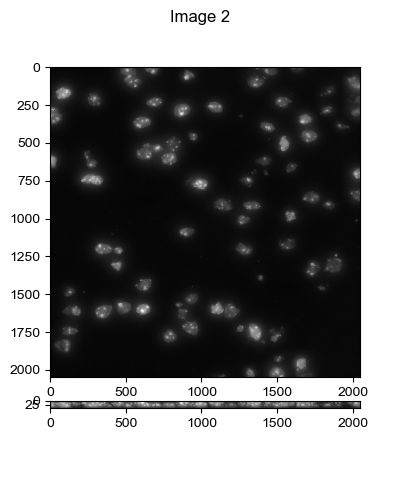

In [18]:
visual_tools.imshow_mark_3d_v2([before_fov.dapi_im, after_fov.dapi_im])

In [16]:
before_fov._load_dapi_image()

-- choose dapi images from folder: \\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\Before_clearing\H0R0.
- correct the whole fov for image: \\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\Before_clearing\H0R0\Conv_zscan_05.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\Before_clearing\H0R0\Conv_zscan_05.dax  in 5.329s
-- removing hot pixels for channels:['405'] in 26.122s
-- illumination correction for channels: 405, in 5.123s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 37.922s
-- saving fov_info to file: \\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\before_clearing\Conv_zscan_05.hdf5
++ base attributes saved:['dapi_im'] in 31.827s.


array([[[ 837, 1021,  816, ...,  889,  939,  963],
        [ 958,  986,  816, ..., 1148,  960,  803],
        [ 948,  859,  907, ...,  942, 1006,  932],
        ...,
        [1115, 1127, 1178, ..., 1048,  998, 1152],
        [1090, 1083, 1190, ..., 1069, 1144, 1006],
        [1124, 1039, 1056, ..., 1076, 1022,  988]],

       [[ 996,  980,  907, ...,  954, 1031,  932],
        [ 861,  960,  859, ...,  979,  849,  929],
        [ 948,  924,  986, ...,  877, 1003, 1000],
        ...,
        [1171, 1124, 1124, ...,  920, 1204, 1110],
        [1130, 1137, 1002, ..., 1043, 1001, 1032],
        [ 999, 1125, 1061, ..., 1058, 1012, 1056]],

       [[ 804, 1031,  942, ...,  960, 1065, 1013],
        [ 932,  873,  912, ...,  960,  754, 1000],
        [ 891,  974,  932, ...,  892,  871,  920],
        ...,
        [1102, 1185, 1141, ..., 1157, 1066, 1116],
        [1132, 1076, 1090, ..., 1022, 1196, 1009],
        [1017, 1283, 1054, ..., 1076, 1014, 1188]],

       ...,

       [[1371, 1229, 118

In [17]:
after_fov._load_dapi_image()

-- choose dapi images from folder: \\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\After_clearing\H0R0.
- correct the whole fov for image: \\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\After_clearing\H0R0\Conv_zscan_05.dax
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2048x2048.npy
-- loading image from file:\\dolly\Raw_data_5\shiwei\20201221-Acr_ctp08_P_brain\After_clearing\H0R0\Conv_zscan_05.dax  in 5.007s
-- removing hot pixels for channels:['405'] in 27.931s
-- illumination correction for channels: 405, in 3.934s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 37.883s
-- saving fov_info to file: \\crick\Shiwei_Data_1\20201221-Acr_ctp08_P_brain\After_clearing\Conv_zscan_05.hdf5
++ base attributes saved:['dapi_im'] in 29.853s.


array([[[357, 395, 422, ..., 514, 511, 474],
        [278, 353, 375, ..., 498, 504, 477],
        [314, 363, 355, ..., 492, 434, 387],
        ...,
        [294, 316, 383, ..., 395, 439, 486],
        [262, 358, 336, ..., 426, 403, 385],
        [333, 327, 343, ..., 455, 429, 353]],

       [[334, 373, 345, ..., 449, 566, 464],
        [355, 351, 326, ..., 455, 434, 511],
        [335, 373, 393, ..., 511, 434, 483],
        ...,
        [343, 322, 371, ..., 447, 434, 429],
        [331, 321, 290, ..., 478, 437, 439],
        [304, 344, 314, ..., 486, 382, 502]],

       [[347, 339, 407, ..., 532, 557, 471],
        [324, 367, 369, ..., 501, 455, 514],
        [355, 328, 349, ..., 532, 504, 452],
        ...,
        [341, 312, 292, ..., 413, 377, 437],
        [295, 348, 339, ..., 442, 348, 418],
        [360, 341, 368, ..., 426, 442, 405]],

       ...,

       [[367, 339, 438, ..., 729, 754, 806],
        [428, 330, 405, ..., 705, 575, 745],
        [365, 399, 407, ..., 692, 655, 772

In [14]:
visual_tools.imshow_mark_3d_v2([before_fov.chrom_im, after_fov.chrom_im])

<IPython.core.display.Javascript object>

## visualize chromosomes selections

In [8]:
# convert into indices
before_fov_inds_list = np.zeros(len(before_fov_ids_list), dtype=np.int)

for _i, _id in enumerate(np.unique(before_fov_ids_list)):
    before_fov_inds_list[before_fov_ids_list==_id] = _i

<IPython.core.display.Javascript object>


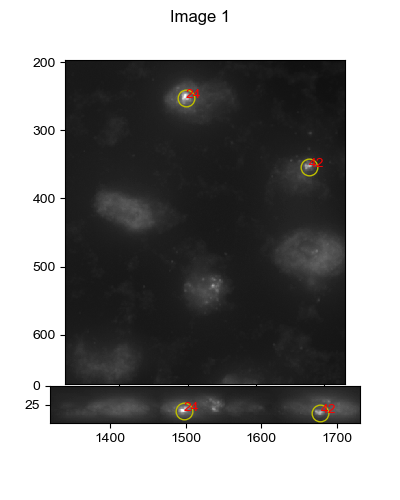

In [9]:
%matplotlib notebook
%matplotlib notebook
## visualize
before_coord_dict = {'coords':[np.flipud(_coord) for _coord in before_chrom_coords],
                     'class_ids':list(before_fov_inds_list),
                    }

visual_tools.imshow_mark_3d_v2(before_chrom_ims, 
                               given_dic=before_coord_dict,    # param to show selection
                               save_file=None,
                               )


# EM pick spots

## threshold spots based on dist to chr center

In [17]:
# select_hzxys close to the chromosome center
dist_th = 5000 # upper limit is 5000nm
intensity_th = 200 
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th) & (_cands[:,0]>=intensity_th)])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

## EM pick spots

In [40]:
nkeep

1366

- iter:0
- generate reference metrics from picked chrs.
-- multiprocessing process references with 15 threads, in 15.410s
-- collapse all regions into 1d.


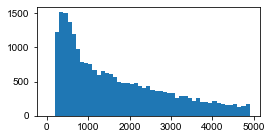

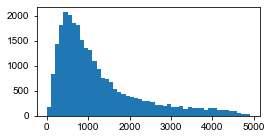

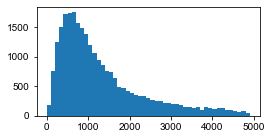

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 15 threads, in 11.518s
-- region kept: 0.7641
- iter:1
- generate reference metrics from picked chrs.
-- multiprocessing process references with 15 threads, in 10.376s
-- collapse all regions into 1d.


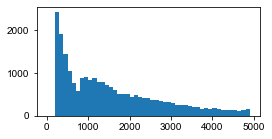

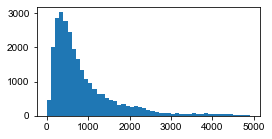

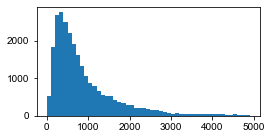

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 15 threads, in 11.228s
-- region kept: 0.9123
- iter:2
- generate reference metrics from picked chrs.
-- multiprocessing process references with 15 threads, in 10.661s
-- collapse all regions into 1d.


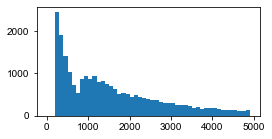

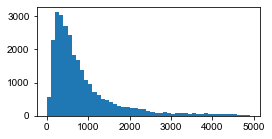

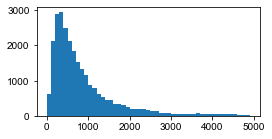

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 15 threads, in 11.255s
-- region kept: 0.9557
- iter:3
- generate reference metrics from picked chrs.
-- multiprocessing process references with 15 threads, in 10.597s
-- collapse all regions into 1d.


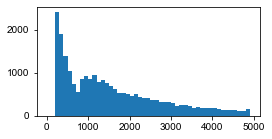

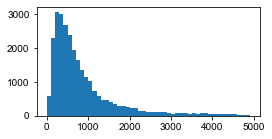

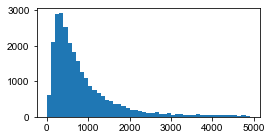

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 15 threads, in 11.525s
-- region kept: 0.9712
- iter:4
- generate reference metrics from picked chrs.
-- multiprocessing process references with 15 threads, in 11.530s
-- collapse all regions into 1d.


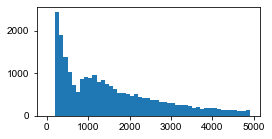

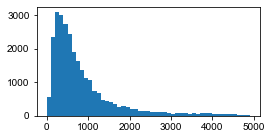

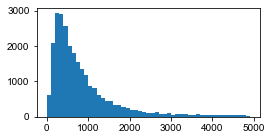

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 15 threads, in 11.419s
-- region kept: 0.9813
- iter:5
- generate reference metrics from picked chrs.
-- multiprocessing process references with 15 threads, in 10.608s
-- collapse all regions into 1d.


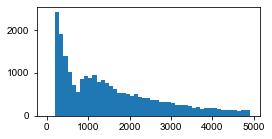

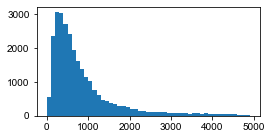

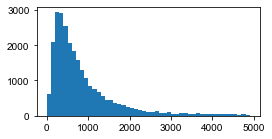

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 15 threads, in 11.431s
-- region kept: 0.9858
- iter:6
- generate reference metrics from picked chrs.
-- multiprocessing process references with 15 threads, in 10.605s
-- collapse all regions into 1d.


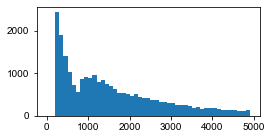

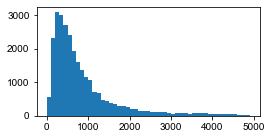

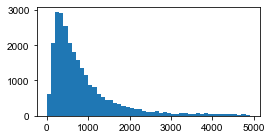

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 15 threads, in 12.887s
-- region kept: 0.9867
- iter:7
- generate reference metrics from picked chrs.
-- multiprocessing process references with 15 threads, in 14.090s
-- collapse all regions into 1d.


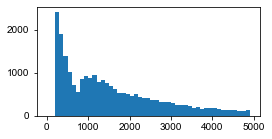

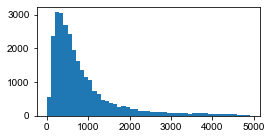

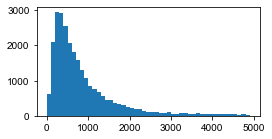

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 15 threads, in 16.168s
-- region kept: 0.9863
- iter:8
- generate reference metrics from picked chrs.
-- multiprocessing process references with 15 threads, in 15.511s
-- collapse all regions into 1d.


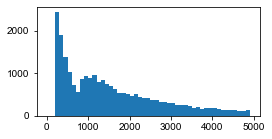

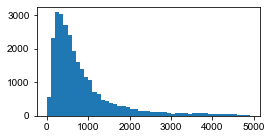

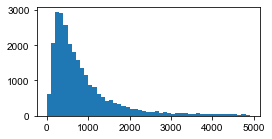

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 15 threads, in 14.336s
-- region kept: 0.9869
- iter:9
- generate reference metrics from picked chrs.
-- multiprocessing process references with 15 threads, in 12.826s
-- collapse all regions into 1d.


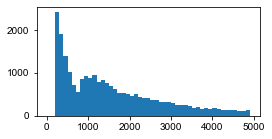

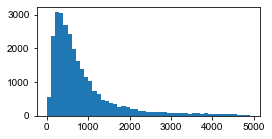

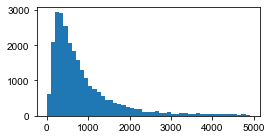

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 15 threads, in 26.967s
-- region kept: 0.9869


In [20]:
# load functions
reload(ia.spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import Pick_spots_by_intensity, EM_pick_scores_in_population, generate_reference_from_population,evaluate_differences

%matplotlib inline
niter= 10
nkeep = len(sel_dna_cand_hzxys_list)
num_threads = 15
# initialize
init_dna_hzxys = Pick_spots_by_intensity(sel_dna_cand_hzxys_list[:nkeep])
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []
for _iter in range(niter):
    print(f"- iter:{_iter}")
    # generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1][:nkeep], dna_reg_ids,
        num_threads=num_threads,
        collapse_regions=True,
    )
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ints), bins=np.arange(0,5000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ct_dists), bins=np.arange(0,5000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_local_dists), bins=np.arange(0,5000,100))
    plt.show()
    # scoring
    sel_hzxys, sel_scores, all_scores = EM_pick_scores_in_population(
            sel_dna_cand_hzxys_list[:nkeep], dna_reg_ids, sel_dna_hzxys_list[-1], 
            ref_ct_dists, ref_local_dists, ref_ints,
            sel_dna_hzxys_list[-1], dna_reg_ids, num_threads=num_threads,
        )
    update_rate = evaluate_differences(sel_hzxys, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    sel_dna_hzxys_list.append(sel_hzxys)
    sel_dna_scores_list.append(sel_scores)
    all_dna_scores_list.append(all_scores)
    
    if update_rate > 0.995:
        break

In [65]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = np.exp(-7)
int_th = 800
bad_spot_percentage = 0.5

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    _bad_inds = _kept_hzxys[:,0] < int_th
    _kept_hzxys[_bad_inds] = np.nan
    #_kept_hzxys[_scores < score_th] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

0.2770131308337288


<IPython.core.display.Javascript object>


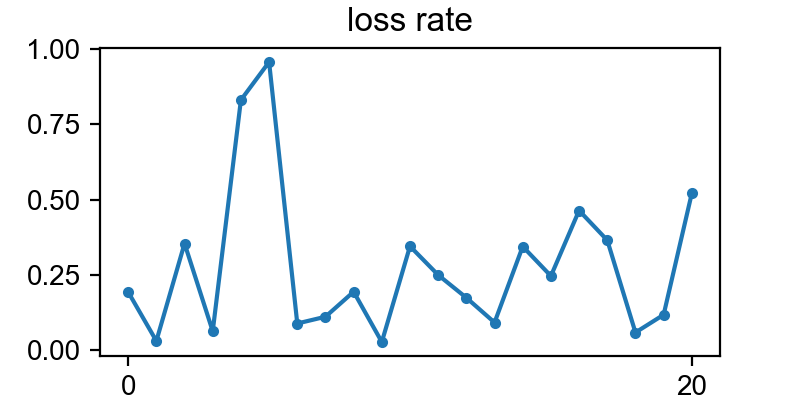

In [71]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
print(np.mean(loss_rates))
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_title(f"loss rate")
ax.set_xticks(np.arange(0,len(fov.unique_ids),20))
plt.show()

In [69]:
print(len(distmap_list))

1204


In [67]:
kept_inds = np.where(loss_rates<0.5)[0]

<IPython.core.display.Javascript object>


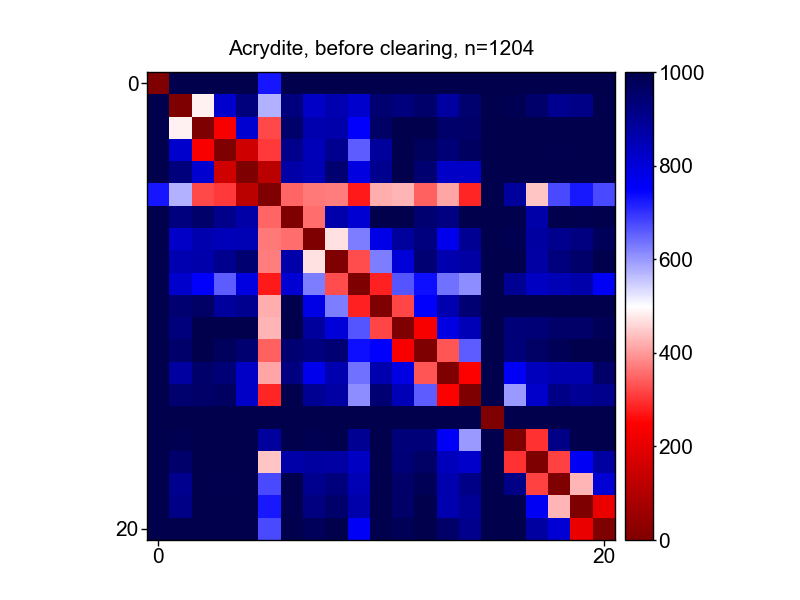

In [70]:
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,1000],
                                               ax=ax,
                                               ticks=np.arange(0,len(fov.unique_ids),20), 
                                               figure_dpi=200)
ax.set_title(f"Acrydite, before clearing, n={len(distmap_list)}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

## visualize selected spots

In [44]:
kept_chrom_coords = chrom_coords[kept_chr_ids]
kept_fov_inds_list = fov_inds_list[kept_chr_ids]

In [14]:
# convert into indices
fov_inds_list = np.zeros(len(fov_ids_list), dtype=np.int)

for _i, _id in enumerate(np.unique(fov_ids_list)):
    fov_inds_list[fov_ids_list==_id] = _i

In [38]:
np.array(final_dna_hzxys_list).shape

(1228, 21, 4)

In [49]:
# visualize fitted spots for one round of hybridization
hyb_id = 1

print(f"region: u{fov.unique_ids[hyb_id]} in chrom_im")

%matplotlib notebook
%matplotlib notebook
## visualize
coord_dict = {'coords':[np.flipud(_coord) for _coord in np.array(final_dna_hzxys_list)[:,hyb_id,1:]/fov.shared_parameters['distance_zxy']],
              'class_ids':list(kept_fov_inds_list),
             }

visual_tools.imshow_mark_3d_v2(chrom_ims, 
                               given_dic=coord_dict,    # param to show selection
                               save_file=None,
                               )


region: u95 in chrom_im


<IPython.core.display.Javascript object>